## <a id='top'></a>

# CSCI 3202, Fall 2020
# Assignment 2
# Due: Friday 25 September 2020 by 11:59 PM

<br> 

### Your name:

<br> 

## Problem 1 (15 points)

Consider the directed state space graph below.

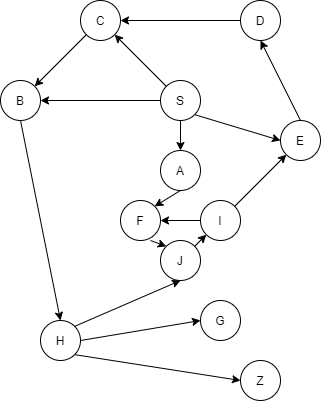

Suppose we wish to find the shortest edge-length path from the start node `S` to the goal node `G`.  Additionally, we have access to the heuristic of "straight line distance from the given node to `G`."


For each of the following search algorithms, what is the full route chosen from `S` to `G`?  For any algorithms that require an order by which to choose/queue equivalent nodes, assume that we open nodes alphabetically.

#### 1a) Breadth-First Search

BFS will find the shortest path in terms of number edges, which is SBHG.

#### 1b) Depth-First Search

DFS will take a while, and will follow a chain that begins with A: AFJIEDCBHG

#### 1c) Greedy Best-First, with straight-line-distance heuristic


The greedy algorithm fails here.  It goes from A to F after which is just loops from FJIFJIFJI, etc.

#### 1d) A$^*$, with straight-line-distance heuristic


Straight-line distance is consitent and admissible if the goal metric is edge distance, so A* will find the optimal route of SBHG

#### 1e) Describe what properties of this graph may or may not have led to different paths from the algorithms above.

The main things to consider are the split between DFS/BFS due to the long alternate route through S->A and the failure of the greedy algorithm due to a spider trap/loop that existing between S and G.



## Problem 2 (30 points)

### Escape from Chicago

It is the year 2030 and a freak earthquake has caused Chicago to break off from the mainland of Illinois. It has drifted out into Lake Michigan and is now used as a penal colony for the United States' worst criminals.  Snake Plisskin, world-famous tough guy and amateur sea lion enthusiast, must travel from Chicago to New York to find the antidote to the *Plutoxin 7 poison* that he and many other Chicagoans have been infected with.

Below are crude graphs, representing the northeastern United States.  The graph on the left, **map_distances**, represents the step costs between two states on the graph (cities) using the distance between the two cities along major highways.  On the right, **map_times** represents the step costs using estimated travel time (at 5 PM on a Friday, east coast time).  These graphs are defined in the helper routines at below.

If you take a look at those graphs, you will notice that for brevity's sake, we will use **lowercase** abbreviations for each city, consisting of the **first 3 letters** of the city's name.  So Providence is represented by the state 'pro', for example.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats

**map_distances**          |  **map_times**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 550px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1rI5w8CuWOS9reMIewc2IDBp_Z3pSUu1H" alt="Drawing" style="width: 550px;"/>

### Useful helper routines for searching

In [2]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [3]:
map_distances = dict(
    chi=dict(det=283, cle=345, ind=182),
    cle=dict(chi=345, det=169, col=144, pit=134, buf=189),
    ind=dict(chi=182, col=176),
    col=dict(ind=176, cle=144, pit=185),
    det=dict(chi=283, cle=169, buf=256),
    buf=dict(det=256, cle=189, pit=215, syr=150),
    pit=dict(col=185, cle=134, buf=215, phi=305, bal=247),
    syr=dict(buf=150, phi=253, new=254, bos=312),
    bal=dict(phi=101, pit=247),
    phi=dict(pit=305, bal=101, syr=253, new=97),
    new=dict(syr=254, phi=97, bos=215, pro=181),
    pro=dict(bos=50, new=181),
    bos=dict(pro=50, new=215, syr=312, por=107),
    por=dict(bos=107))

map_times = dict(
    chi=dict(det=280, cle=345, ind=200),
    cle=dict(chi=345, det=170, col=155, pit=145, buf=185),
    ind=dict(chi=200, col=175),
    col=dict(ind=175, cle=155, pit=185),
    det=dict(chi=280, cle=170, buf=270),
    buf=dict(det=270, cle=185, pit=215, syr=145),
    pit=dict(col=185, cle=145, buf=215, phi=305, bal=255),
    syr=dict(buf=145, phi=245, new=260, bos=290),
    bal=dict(phi=145, pit=255),
    phi=dict(pit=305, bal=145, syr=245, new=150),
    new=dict(syr=260, phi=150, bos=270, pro=260),
    pro=dict(bos=90, new=260),
    bos=dict(pro=90, new=270, syr=290, por=120),
    por=dict(bos=120))

sld_providence = dict(
    chi=833,
    cle=531,
    ind=782,
    col=618,
    det=596,
    buf=385,
    pit=458,
    syr=253,
    bal=325,
    phi=236,
    new=157,
    pro=0,
    bos=38,
    por=136)

def check_map(step_costs):
    ''' function to check if all the path costs are at least symmetric '''
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

<a id='p1a'></a>
### (2a)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using breadth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `map_distances`) along the list of states **path**

In [4]:
# Solution:

def breadth_first(start, goal, state_graph, return_cost=False):
    ''' find a shortest sequence of states from start to the goal '''
    frontier = deque([start]) # doubly-ended queue of states
    previous = {start: None}  # start has no previous state; other states will
    if start == goal:
        path_out = [start]
        if return_cost: return path_out, pathcost(path_out, state_graph)
        return path_out
    while frontier:
        s = frontier.popleft()
        for s2 in state_graph[s]:
            if s2 not in previous:
                frontier.append(s2)
                previous[s2] = s
                if s2 == goal:
                    path_out = path(previous, s2)
                    if return_cost: return path_out, pathcost(path_out, state_graph)
                    return path_out


<a id='p1b'></a>
### (2b)

#### Depth-first search

Implement a function **depth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using depth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
    * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
    * If **False**, then the only output is the solution path list object

In [5]:
# Solution:

def depth_first(start, goal, state_graph, return_cost=False):
    ''' find a sequence of states from start to the goal '''
    frontier = [start] # regular Python list works as LIFO queue
    previous = {start: None}  # start has no previous state; other states will
    if start == goal:
        path_out = [start]
        if return_cost: return path_out, pathcost(path_out, state_graph)
        return path_out
    while frontier:
        s = frontier.pop()
        for s2 in state_graph[s]:
            if s2 not in previous:
                frontier.append(s2)
                previous[s2] = s
                if s2 == goal:
                    path_out = path(previous, s2)
                    if return_cost: return path_out, pathcost(path_out, state_graph)
                    return path_out


<a id='p1c'></a>
### (2c)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the `heapq` package is imported in the helpers at the bottom of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** is the initial state (e.g., **start**='chi')
  * **cost** is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states**: maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q**: a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. I only suggest to code it in this way because I think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [6]:
# Solution:

class Frontier_PQ:
    ''' frontier class for uniform search, ordered by path cost '''
    
    def __init__(self, start, cost):
        self.states = {}
        self.q = []
        self.add(start, cost)
        
    def add(self, state, cost):
        ''' push the new state and cost to get there onto the heap'''
        heapq.heappush(self.q, (cost, state))
        self.states[state] = cost

    def pop(self):
        (cost, state) = heapq.heappop(self.q)  # get cost of getting to explored state
        self.states.pop(state)    # and remove from frontier
        return (cost, state)

    def replace(self, state, cost):
        ''' found a cheaper route to `state`, replacing old cost with new `cost` '''
        self.states[state] = cost
        for i, (oldcost, oldstate) in enumerate(self.q):
            if oldstate==state and oldcost > cost:
                self.q[i] = (cost, state)
                heapq._siftdown(self.q, 0, i) # now i is posisbly out of order; restore
        return
    

Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **map_distances** or **map_times** below)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [7]:
# Solution:

def uniform_cost(start, goal, state_graph, return_cost=False):
    frontier = Frontier_PQ(start, 0)
    previous = {start : None}
    explored = {}
    while frontier:
        s= frontier.pop()
        if s[1] == goal:
            if return_cost: return path(previous, s[1]), s[0]
            return path(previous, s[1])
        explored[s[1]] = s[0]
        for s2 in state_graph[s[1]]:
            newcost = explored[s[1]]+state_graph[s[1]][s2]
            if (s2 not in explored) and (s2 not in frontier.states):
                frontier.add(s2, newcost)
                previous[s2] = s[1]
            elif (s2 in frontier.states) and (frontier.states[s2] > newcost):
                frontier.replace(s2, newcost)
                previous[s2] = s[1]

<a id='p1d'></a>
### (2d)

In the code cell below, use a few **print** statements to showcase the output of each of your three search algorithms defined above (in **1a**, **1b** and **1c**) to find routes for Snake to travel from Chicago to New York, with path costs defined by the distance between cities.

Then, in the markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path?
* Why does this not surprise you?

In [8]:
# Solution:

start = 'chi'
goal = 'new'
graph = map_distances
print(uniform_cost(start, goal, graph, True))
print(depth_first(start, goal, graph, True))
print(breadth_first(start, goal, graph, True))

(['chi', 'cle', 'pit', 'phi', 'new'], 881)
(['chi', 'ind', 'col', 'pit', 'phi', 'new'], 945)
(['chi', 'det', 'buf', 'syr', 'new'], 943)


**Solution:**
* Uniform-cost search yields the shortest path.
* This does not surprise me because we know it is optimal, whereas depth-first and breadth-first search are not.

<a id='p1e'></a>
### (2e)

The Plutoxin 7 poison (which Snake has been infected with) will cause Snake's central nervous system to implode after exactly 1000 minutes.

Will any of the paths found in **(1d)** get Snake to New York alive?  Show your work! Snake's life hangs in the balance.

In [9]:
# Solution:

start = 'chi'
goal = 'new'
graph = map_distances
time_uniform = pathcost(uniform_cost(start, goal, graph), map_times)
time_depth = pathcost(depth_first(start, goal, graph), map_times)
time_breadth = pathcost(breadth_first(start, goal, graph), map_times)
print('Estimated time for uniform-cost search path: {} minutes'.format(time_uniform))
print('Estimated time for depth-first search path: {} minutes'.format(time_depth))
print('Estimated time for breadth-first search path: {} minutes'.format(time_breadth))
print('---------------------------------------------------------')
if time_uniform >= 1000 and time_depth >= 1000 and time_breadth >= 1000:
    print('--> Nope, Snake is a goner')
else:
    print('--> There is hope!')

Estimated time for uniform-cost search path: 945 minutes
Estimated time for depth-first search path: 1015 minutes
Estimated time for breadth-first search path: 955 minutes
---------------------------------------------------------
--> There is hope!


<a id='p1f'></a>
### (2f)

Since time is a factor, Snake ought to optimize his route from Chicago to New York to minimize the total time required. Because Snake is a renaissance man, he knows some pretty slick search algorithms.  But because he's infected with deadly poison, Snake just isn't up to the task of implementing them - his code is full of bugs and he keeps sneezing all over his monitor!  Let's help him out, shall we?

In the code cell below, find the shortest path from Chicago to New York as measured by total time taken, and display the result using a **print** statement

In the markdown cell below the code cell, write a couple of sentences:
* Why did you choose the search algorithm and state space graph that you chose?
* Would the solution path found by the other algorithms (the ones you didn't use in your function call) change if you tried to optimize based on time as opposed to distance (i.e., used **map_times** as opposed to **map_distances**)? Why or why not?
* **Most importantly:**  will Snake get to New York in time to receive the Plutoxin 7 antidote? This answer should be justified by your code output.

In [10]:
# Solution:

start = 'chi'
goal = 'new'
graph = map_times
print(uniform_cost(start, goal, graph, True))

(['chi', 'cle', 'buf', 'syr', 'new'], 935)


** Solution:**
* I used uniform-cost search because it is optimal, and **map_times** so the search will find the optimal path based on minimizing total time taken.
* Depth-first and breadth-first searches would **not** yield different results because they do not consider step costs at all in the decision-making process.  So only the order in which states are placed on the frontier.
* Snake will arrive in New York with an hour and five minutes left to receive the antidote. Phew!

## Problem 3 (25 points)

Well, it turns out Snake used the right algorithms and lived through his perilous trip to New York City.  He returned to Chicago, where he is living happily among the criminals, sea lions and criminal sea lions  But we want a sequel!

During Snake's time on the east coast, he came to realize that the soothing Atlantic Ocean air does wonders for his nerves. Living in the penal colony of Chicago is just so stressful! So he has decided to pack up and move to Providence, Rhode Island.

Because Snake has traveled across the country already, he has some prior knowledge regarding how far various cities along the way are from his final destination of Providence.  In particular, Snake maps out the **straight-line distance** from major cities to Providence. This information is displayed graphically below, on a tattoo on Kurt Russell's forearm (you can't prove that isn't true), and in the `sld_providence` dictionary in the [helper functions] at the top of this notebook.

Also note that because it doesn't make much sense to add estimated travel times and the straight-line distance, we will only be using the `map_distances` state space graph for this problem.

**map_distances**          |  **sld_providence**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 500px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1a8FNEG7apKkRX7VvpdMgmeYbqeNuOdwz" alt="Drawing" style="width: 500px;"/>


<a id='p1a'></a>
### (3a)

Modify your code for uniform-cost search from Problem 1 so that it provides optionally as output the number of nodes **expanded** in completing the search. 

Include a new optional logical (True/False) argument **return_nexp**, so your function calls to the new uniform cost search will look like: `uniform_cost(start, goal, state_graph, return_cost, return_nexp)`.
* If `return_nexp` is True, then the last output in the output tuple should be the number of nodes expanded.
* If `return_nexp` is False, then the code should behave exactly as it does in problem 2.

Then, verify that your revised codes are working by checking Snake's optimal route from Chicago to New York. Include the number of nodes expanded and the path cost (using `map_distances`).

In [11]:
# Solution:

class Frontier_PQ:
    ''' frontier class for uniform search, ordered by path cost '''
    
    def __init__(self, start, cost):
        self.states = {}
        self.q = []
        self.add(start, cost)
        
    def add(self, state, cost):
        ''' push the new state and cost to get there onto the heap'''
        heapq.heappush(self.q, (cost, state))
        self.states[state] = cost

    def pop(self):
        (cost, state) = heapq.heappop(self.q)  # get cost of getting to explored state
        self.states.pop(state)    # and remove from frontier
        return (cost, state)

    def replace(self, state, cost):
        ''' found a cheaper route to `state`, replacing old cost with new `cost` '''
        self.states[state] = cost
        for i, (oldcost, oldstate) in enumerate(self.q):
            if oldstate==state and oldcost > cost:
                self.q[i] = (cost, state)
                heapq._siftdown(self.q, 0, i) # now i is posisbly out of order; restore
        return

def uniform_cost(start, goal, state_graph, return_cost=False, return_nexp=True):
    frontier = Frontier_PQ(start, 0)
    previous = {start : None}
    explored = {}
    n_exp = 0
    while frontier:
        s = frontier.pop()
        n_exp += 1
        #print('exploring {}'.format(s[1]))
        if s[1] == goal:
            if return_cost: return (path(previous, s[1]), s[0], n_exp) if return_nexp else (path(previous, s[1]), s[0])
            return path(previous, s[1])
        explored[s[1]] = s[0]
        for s2 in state_graph[s[1]]:
            newcost = explored[s[1]] + state_graph[s[1]][s2]
            if (s2 not in explored) and (s2 not in frontier.states):
                frontier.add(s2, newcost)
                previous[s2] = s[1]
            elif (s2 in frontier.states) and (frontier.states[s2] > newcost):
                frontier.replace(s2, newcost)
                previous[s2] = s[1]
                
print(uniform_cost('chi','new', map_distances, True, True))

(['chi', 'cle', 'pit', 'phi', 'new'], 881, 11)


### (3b)

#### Heuristic function

Define a function to take as an argument the `state` that Snake is in (city on our graphs), and return as output the value of the straight-line distance heuristic, between Snake's `state` and Providence.  Note that your function should be quite short, and amounts to looking up the proper value from the `sld_providence` dictionary defined in the [helper functions](#helper).  Call this function `heuristic_sld_providence`.


In [12]:
# Solution:

def heuristic_sld_providence(state):
    return sld_providence[state]

### (3c)

#### Full-blown A\* search

We are finally ready to help Snake use his knowledge of straight-line distances from various cities to Providence to inform his path-finding from Chicago to Providence!

Modify your uniform-cost search codes from **(2a)** even further so that they now perform **A\* search**, using as the heuristic function the straight-line distance to Providence.

Provide `heuristic` as an additional argument, which should just be the function name to call within the A\* code. So your call to the A\* routine should look like:  `astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp)`.  (This kind of modular programming will make it much easier to swap in alternative heuristic functions later, and also helps to facilitate debugging if something goes wrong.)

In [13]:
# Solution:

def astar_search(start, goal, state_graph, heuristic, return_cost=False, return_nexp=False):
    '''A* search from `start` to `goal`
    start = initial state
    goal = goal state
    heuristic = function for estimated cost to goal (function name)
    return_cost = logical (True/False) for whether or not to return the total path cost
    return_nexp = logical (True/False) for whether or not to return the number of nodes expanded
    '''         
    frontier = Frontier_PQ(start, 0)
    previous = {start : None}
    explored = {}
    n_exp = 0
    while frontier:
        s = frontier.pop()
        n_exp += 1
        #print('exploring {}'.format(s[1]))
        if s[1] == goal:
            if return_cost:
                if return_nexp:
                    return (path(previous, s[1]), pathcost(path(previous, s[1]), state_graph), n_exp)
                    #return (path(previous, s[1]), pathcost(path(previous, s[1]), state_graph), len(explored))
                else:
                    return (path(previous, s[1]), pathcost(path(previous, s[1]), state_graph))
            else:
                if return_nexp:
                    return (path(previous, s[1]), n_exp)
                else:
                    return path(previous, s[1])
        explored[s[1]] = pathcost(path(previous, s[1]), state_graph)
        for s2 in state_graph[s[1]]:
            newcost = explored[s[1]] + state_graph[s[1]][s2] + heuristic(s2)
            if (s2 not in explored) and (s2 not in frontier.states):
                frontier.add(s2, newcost)
                previous[s2] = s[1]
            elif (s2 in frontier.states) and (frontier.states[s2] > newcost):
                frontier.replace(s2, newcost)
                previous[s2] = s[1]
  

### (3d)

Snake has already made it to Buffalo on his own, but he is growing weary.  There were ***so*** many sea lions along the way, and he had to stop and admire their grace and beauty.  Use your A\* search code from **(3c)** to help Snake find the optimal path **by distance traveled** the rest of the way to Providence.  Print to the screen the following:
1. the optimal path
2. the optimal path cost (miles traveled)
3. the number of states expanded during the A\* search

Additionally, show below how many states must be expanded to find the optimal path from Buffalo to Providence using the regular old uniform-cost search algorithm from **(3a)**.  Comment on the difference in states that must be explored by each algorithm.

**Sanity check:** No matter what your `start` and `goal` states are, how should the output from `astar_search` and `uniform_cost` search compare?

In [14]:
# Solution:

start = 'buf'
goal = 'pro'
print(astar_search(start, goal, map_distances, heuristic_sld_providence, return_cost=True, return_nexp=True))
print(uniform_cost(start, goal, map_distances, return_cost=True, return_nexp=True))

(['buf', 'syr', 'bos', 'pro'], 512, 4)
(['buf', 'syr', 'bos', 'pro'], 512, 12)


**Solution:**

Uniform-cost search explored more states, which makes sense, because it is uninformed and searching in all directions only based on how far those states are from the initial state.


## Problem 4 (30 points)

Consider this maze, where gray tiles represent walls and orange tiles represent open space where you can walk.

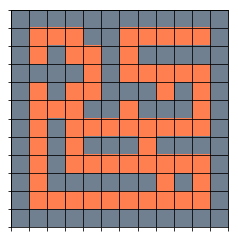

We can represent this maze using a binary `numpy` array as follows, where 1s represent walls and 0s represent open space:

In [15]:
maze = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
                 [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

**Very importantly**, note that the *first* row of the **maze** array corresponds to the *bottom* row of tiles in the figure.  This is a choice made carefully to reflect the fact that we are going to search for a solution path through this maze in *physical* space, so it is useful for our coordinate system to match Cartesian coordinates. This is in contrast to using the first row of the **maze** array to represent the top of the maze, which looks intuitive.

<a id='p3a'></a>
### (4a)

Write a function **maze_to_graph(maze)** that:
* takes as input a binary maze **maze**, stored as a `numpy` array, where 0 represents an open path and 1 represents a wall
* returns a graph dictionary in a similar style to **map_distances** and **map_times** (from Problem 1)
  * the keys are tuples giving the states (coordinate pairs) within the maze (e.g., (1,1) represents the lower-left open space, (2,1) represents the space **to the right** of (1,1), and (0,0) represents the lower-left corner, a wall location); thus, the coordinates within the maze are like Cartesian coordinates, and the x- and y-axes are the bottom and left walls of the maze, respectively
  * the values are themselves dictionaries, where the keys are other states within the maze and the values are the actions taken to move to that state
  * the actions are moves from the list ['N','S','E','W']

In [16]:
# Solution:

def maze_to_graph(maze):
    ''' takes in a maze as a numpy array, converts to a graph '''
    nrow = maze.shape[0]
    ncol = maze.shape[1]
    graph = {(i, j): {} for i in range(ncol) for j in range(nrow) if not maze[j,i]}
    for col, row in graph.keys():
        if row < nrow - 1 and not maze[row + 1, col]:
            graph[(col, row)][(col, row + 1)] = "N"
            graph[(col, row + 1)][(col, row)] = "S"
        if col < ncol - 1 and not maze[row, col + 1]:
            graph[(col, row)][(col + 1, row)] = "E"
            graph[(col + 1, row)][(col, row)] = "W"
    return graph

<a id='p3b'></a>
### (4b)

Use your **maze_to_graph** function and **depth-first search** to solve the maze defined above.  A simple 'print' statement of the path your codes find and its length suffices.
* The initial state is (1,1)
* The goal state is (10,10)

Then, use your **breadth-first search** function to solve the maze; provide the solution path and its length.

If your codes are sufficiently general, the output from **maze_to_graph** should be suitable to be fed straight into your search routines.

In [17]:
# Solution:

g_maze = maze_to_graph(maze)

maze_sol_dfs = depth_first((1,1), (10,10), g_maze)
print('Depth-first search yields: {}, ({} steps)'.format(maze_sol_dfs, len(maze_sol_dfs)))

maze_sol_bfs = breadth_first((1,1), (10,10), g_maze)
print('Breadth-first search yields: {} ({} steps)'.format(maze_sol_bfs, len(maze_sol_bfs)))

Depth-first search yields: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (10, 3), (9, 3), (8, 3), (7, 3), (7, 4), (7, 5), (8, 5), (9, 5), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)], (33 steps)
Breadth-first search yields: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)] (29 steps)


<a id='p3c'></a>
### (4c)

Write a function **plot_maze(maze, path)** that takes as input a binary `numpy` array **maze** (1s represent walls, 0s represent open space) and a solution **path**, and plots the two together.
* **maze**: a maze represented as a binary `numpy` array, as above
* **path**: a solution path found using your search algorithms above. **path** should be consistent with the output from the **path** function below in the helpers (a list of states).  You may find it useful to provide a default of `None` for **path**, so that you can use your function to just plot a maze that you haven't solved yet.

Then, use your **plot_maze** function to plot the maze defined above, along with the solution path found by **depth-first search**.  You may optionally include the breatdh-first solution as well, but make sure it's clear which path was the depth-first path.


<br>

**Potentially useful:** 

[1] In the helpers, you will notice that there are two packages imported:
  * `import matplotlib.pyplot as plt`
  * `from matplotlib import colors`

`pyplot` and `colors` may be potentially useful to you for generating a pretty plot and generating a colormap for your walls/open spaces in the maze, respectively.  You do not need to use them, but I wanted to provide this nudge for folks who maybe have not done much/any plotting in Python before.

[2] Also, [Color Oracle](http://colororacle.org/) is a useful utility for making colorblind-friendly plots. If you ever plan to show another human being a figure that you have generated, this is nice practice. Check it out!

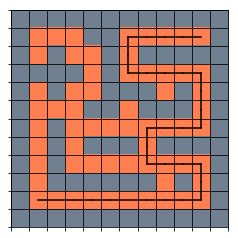

In [18]:
# Solution:

def plot_maze(maze, path=None):
    ''' visualize the binary `maze` (assumed numpy array) and solution `path` (if provided)'''

    nrow, ncol = maze.shape
    
    # create colormap
    cmap = colors.ListedColormap(['coral', 'slategray'])

    fig, ax = plt.subplots()
    ax.imshow(maze, cmap=cmap, origin='lower')
    
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k')
    ax.set_xticks(np.arange(-.5, ncol, 1))
    ax.set_yticks(np.arange(-.5, nrow, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    # now draw the solution path, if one is provided
    if path:
        for p in range(len(path)-1):
            point = path[p]
            nextpoint = path[p+1]
            plt.plot([point[0],nextpoint[0]], [point[1],nextpoint[1]], c='black')
        
    plt.show()
    
plot_maze(maze, path=maze_sol_dfs)

Your maze may differ depending on the order of your up-down-left-right priorty for appending new states to the frontier!